# Cuaderno 1: Exploración y Procesamiento de Datos de Ondas Gravitacionales

**Objetivo:** Familiarizarse con los datos de ondas gravitacionales (OG) utilizando la librería `gwpy`.

En este cuaderno, vamos a realizar los siguientes pasos:
1.  Buscar y descargar los datos del primer evento de OG detectado: **GW150914**.
2.  Visualizar los datos crudos ("strain") para entender el nivel de ruido.
3.  Aplicar técnicas básicas de procesamiento de señal (filtrado y blanqueamiento) para limpiar los datos.
4.  Generar un espectrograma (Q-transform) para visualizar la característica forma de "chirp" de la señal.

In [2]:
# --- Paso 1: Importar las librerías necesarias ---
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries

# Configuramos los gráficos para que se vean mejor
plt.rcParams.update({'font.size': 14})

## 2. Buscar y Descargar Datos del Evento GW150914

GW150914 fue la primera observación directa de ondas gravitacionales, resultado de la fusión de dos agujeros negros. La señal fue detectada por los dos observatorios de LIGO: Hanford (H1) y Livingston (L1).

Usaremos la función `TimeSeries.fetch_open_data` de `gwpy` para descargar los datos de ambos detectores alrededor del momento del evento. El tiempo en la astronomía de OG se mide en segundos GPS.

El tiempo central del evento GW150914 es `1126259462.4`. Vamos a descargar 32 segundos de datos centrados en ese instante.

In [3]:
# Tiempo GPS central del evento
t_event = 1126259462.4

# Descargamos los datos para el detector de Hanford (H1)
# Pedimos 32 segundos de datos, desde t_event - 16s hasta t_event + 16s
h1_data = TimeSeries.fetch_open_data('H1', t_event - 16, t_event + 16)

# Hacemos lo mismo para el detector de Livingston (L1)
l1_data = TimeSeries.fetch_open_data('L1', t_event - 16, t_event + 16)

print("Datos descargados exitosamente:")
print("H1:", h1_data)
print("L1:", l1_data)

Datos descargados exitosamente:
H1: TimeSeries([ 4.11628029e-19,  3.96443979e-19,  3.38344656e-19,
            ..., -6.44526154e-21, -6.36026905e-21,
            -3.74912730e-20]
           unit: dimensionless,
           t0: 1126259446.3999023 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)
L1: TimeSeries([-9.57782180e-19, -9.44008859e-19, -9.68975657e-19,
            ..., -7.18181209e-19, -7.29759972e-19,
            -7.35275811e-19]
           unit: dimensionless,
           t0: 1126259446.3999023 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


## 3. Visualizar los Datos Crudos (Strain)

Ahora vamos a graficar los datos tal y como los miden los detectores. A esta deformación del espacio-tiempo se le llama "strain".

**Observación importante:** La señal de la onda gravitacional es miles de veces más débil que el ruido instrumental. Por lo tanto, será **completamente invisible** en esta primera gráfica. Este es el desafío fundamental que intentamos resolver con IA.

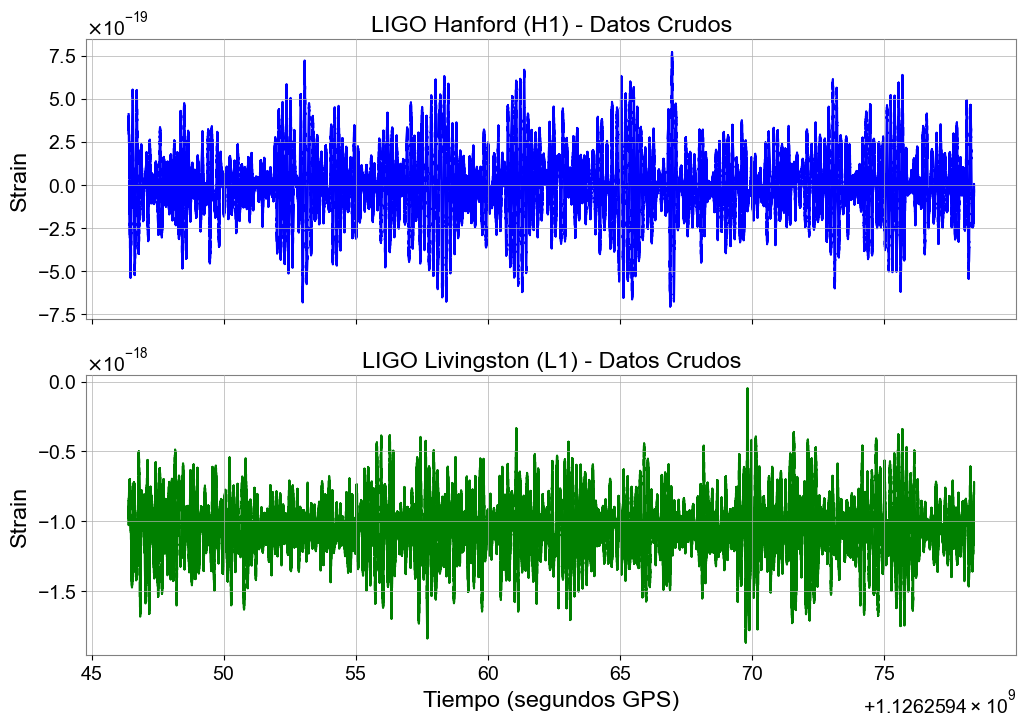

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(h1_data.times, h1_data.value, color='blue')
ax1.set_title("LIGO Hanford (H1) - Datos Crudos")
ax1.set_ylabel("Strain")

ax2.plot(l1_data.times, l1_data.value, color='green')
ax2.set_title("LIGO Livingston (L1) - Datos Crudos")
ax2.set_ylabel("Strain")
ax2.set_xlabel("Tiempo (segundos GPS)")

plt.show()

## 4. Procesamiento de la Señal para Revelar el "Chirp"

Para poder ver la señal, necesitamos limpiar el ruido. Realizaremos dos pasos clave:

1.  **Filtrado de Banda (Band-pass):** Eliminamos las frecuencias muy bajas (ruido sísmico) y muy altas (ruido instrumental) donde no esperamos encontrar la señal. La fusión de agujeros negros como GW150914 emite en un rango aproximado de 30 Hz a 350 Hz.
2.  **Blanqueamiento (Whitening):** Esta técnica aplana el espectro de ruido, de modo que el ruido tenga una potencia similar en todas las frecuencias. Esto hace que la señal, que está concentrada en una banda específica, resalte visualmente.

Aplicaremos estos pasos y volveremos a graficar los datos.

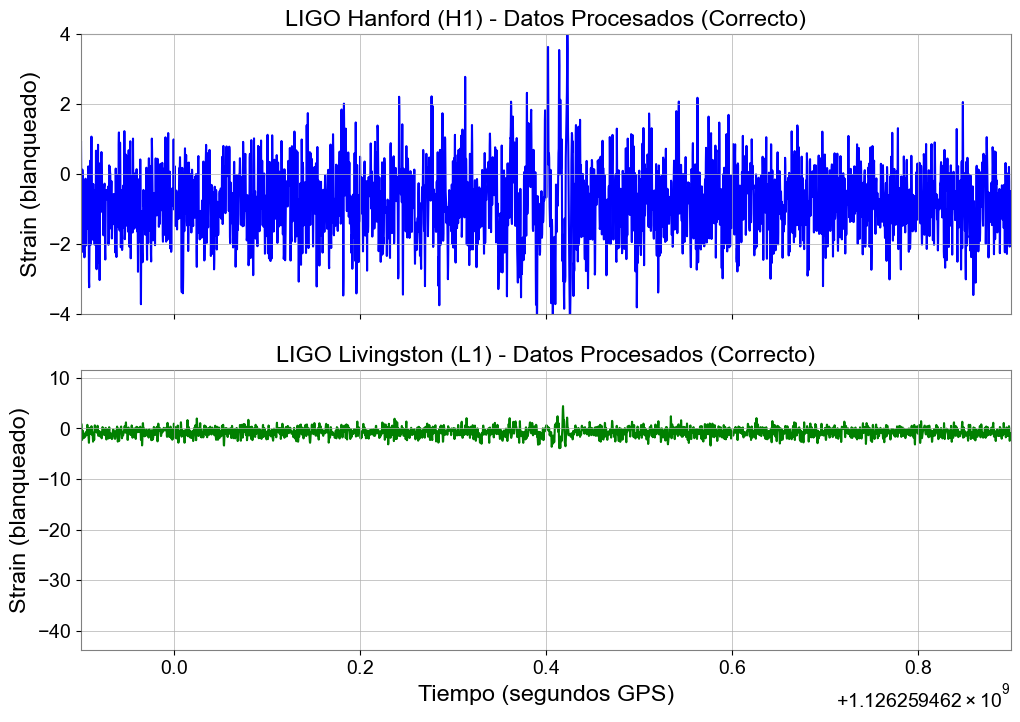

In [19]:
# Centramos el análisis en un periodo más corto de 4 segundos alrededor del evento
t_event = 1126259462.4
h1_data_zoom = TimeSeries.fetch_open_data('H1', t_event - 2, t_event + 2, sample_rate=4096)
l1_data_zoom = TimeSeries.fetch_open_data('L1', t_event - 2, t_event + 2, sample_rate=4096)

# Aplicamos un filtro de banda entre 30 y 350 Hz
h1_cleaned = h1_data_zoom.bandpass(30, 350)
l1_cleaned = l1_data_zoom.bandpass(30, 350)

# Aplicamos blanqueamiento
h1_cleaned = h1_cleaned.whiten()
l1_cleaned = l1_cleaned.whiten()

# Graficamos los datos procesados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(h1_cleaned.times, h1_cleaned.value, color='blue')
ax1.set_title("LIGO Hanford (H1) - Datos Procesados (Correcto)")
ax1.set_ylabel("Strain (blanqueado)")
ax1.set_xlim(t_event - 0.5, t_event + 0.5)
ax1.set_ylim(-4, 4) # Ajustamos el eje Y para ver la señal claramente

ax2.plot(l1_cleaned.times, l1_cleaned.value, color='green')
ax2.set_title("LIGO Livingston (L1) - Datos Procesados (Correcto)")
ax2.set_ylabel("Strain (blanqueado)")
ax2.set_xlabel("Tiempo (segundos GPS)")

plt.show()

## 5. El Espectrograma (Q-Transform): La Visualización Definitiva

Aunque la señal ahora es visible en la serie temporal, la mejor forma de identificar un "chirp" es con un espectrograma, que muestra cómo la **frecuencia de la señal cambia con el tiempo**. Para las ondas gravitacionales, usamos una variante llamada **Q-transform**, que tiene una excelente resolución de tiempo y frecuencia.

La gráfica resultante mostrará un patrón claro: una línea curva que aumenta su frecuencia (sube en el eje Y) a medida que se acerca al momento de la fusión. **Este patrón visual es exactamente lo que una Red Neuronal Convolucional (CNN) está diseñada para reconocer.**

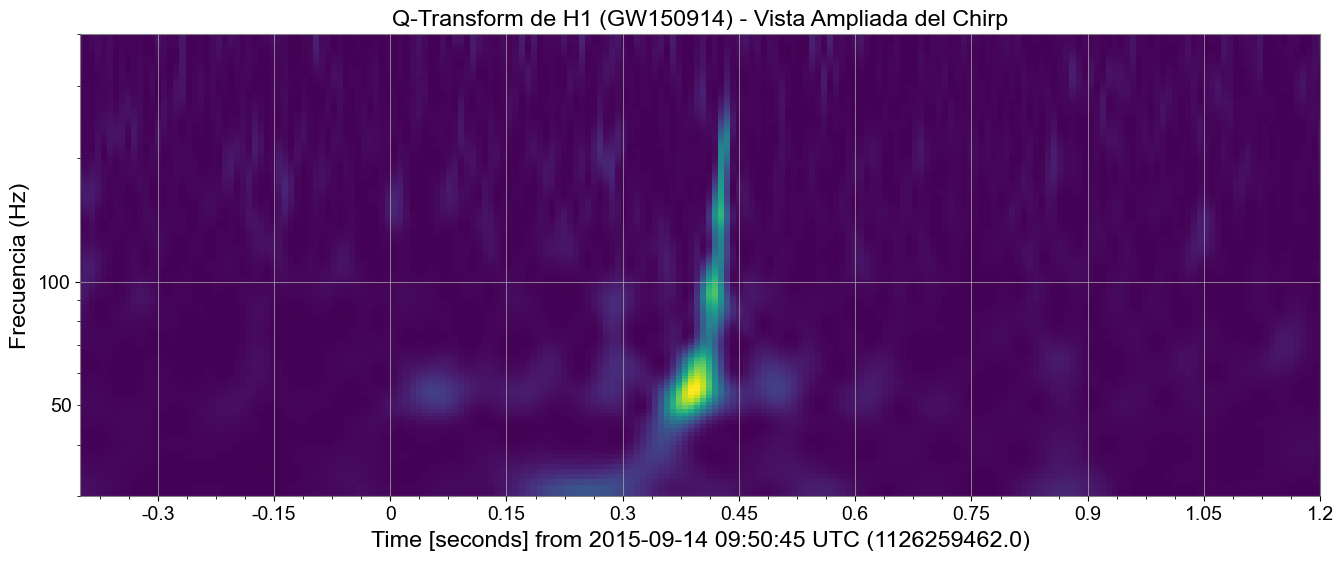

In [26]:
# --- Paso 5 Modificado: Ampliando la vista del Chirp ---

# Usamos los mismos datos y la misma Q-transform que antes
q_transform_h1 = h1_cleaned.q_transform(frange=(30, 400), qrange=(8, 16), tres=1/128., fres=1)

# Para ampliar la vista, ajustaremos el tamaño de la figura (más ancha)
# y estableceremos los límites del eje X para hacer zoom en el evento.
fig = q_transform_h1.plot(figsize=(16, 6), cmap='viridis') # Figura más ancha para enfatizar el tiempo
ax = fig.gca()
ax.set_title("Q-Transform de H1 (GW150914) - Vista Ampliada del Chirp")
ax.set_ylabel("Frecuencia (Hz)")
ax.set_yscale('log')

# --- La clave está aquí: hacer zoom en el eje de tiempo ---
# El evento ocurre en t = 1126259462.4. Nos centraremos en un intervalo
# de solo 0.8 segundos alrededor de ese punto para ver el chirp en detalle.
t_event = 1126259462.4
ax.set_xlim(t_event - 0.8, t_event + 0.8)

ax.grid(True)
plt.show()

### Conclusiones de la Exploración

Hemos logrado:
- Descargar datos reales de un evento confirmado de ondas gravitacionales.
- Comprobar que en su estado crudo, la señal es indistinguible del ruido.
- Aplicar técnicas estándar de procesamiento (`bandpass`, `whiten`) para hacer visible la señal.
- Generar una visualización de tiempo-frecuencia (Q-transform) que muestra el patrón de "chirp" característico.

**Próximos Pasos:**
Ahora que entendemos cómo se ve una señal, el siguiente objetivo es crear un gran conjunto de datos para entrenar nuestros modelos de IA. Esto implicará:
1.  Descargar largos segmentos de ruido puro de los detectores.
2.  Generar muchas formas de onda ("chirps") simuladas con diferentes parámetros (diferentes masas de agujeros negros, etc.).
3.  "Inyectar" estas señales simuladas en el ruido real para crear nuestros ejemplos positivos de entrenamiento.
4.  Segmentar tanto el ruido puro como el ruido con señales en trozos pequeños, listos para ser consumidos por los modelos de Deep Learning.

Este proceso será implementado en los scripts de `src/data_processing/`.